## Spooky Author Identification 
### 무시무시한 글에 대한 작성자 식별
이 경진대회는 할로윈 때 올라 온 경진대회로 호러물에 대한 저자가 누구인지 알아내는 경진대회다.

```
어느 날 양초를 들고 묶여져 있지 않은 책을 들고 으스스한 방을 걷고 있었다. 이제 책이 완성되었다고 생각하고 있는데 갑자기 전화벨이 울리고 Kaggle 중재자 중 가장 무서운 Will이 데이터 유출 소식을 공유했다. 그리고 책을 떨어뜨렸다.
묶여져 있지 않은 글을 쏟아서 뒤죽박죽이 되었다. 이때 저자별로 글을 모아야 하는데 어떻게 해야 할까? 기계학습의 손을 빌려 저자별로 글을 모아본다.
```


* 경진대회 정보 : [Spooky Author Identification | Kaggle](https://www.kaggle.com/c/spooky-author-identification)

* 참고: https://www.kaggle.com/sathvisiva/exploring-spooky-author-dataset


In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
train.shape

(19579, 3)

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
print(train.isnull().sum())

id        0
text      0
author    0
dtype: int64


In [5]:
train['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

1. [EAP - 
Edgar Allan Poe](https://en.wikipedia.org/wiki/Edgar_Allan_Poe): 
[에드거 앨런 포](https://ko.wikipedia.org/wiki/%EC%97%90%EB%93%9C%EA%B1%B0_%EC%95%A8%EB%9F%B0_%ED%8F%AC) 1809년 1월 19일 ~ 1849년 10월 7일)는 미국의 작가·시인·편집자·문학평론가이다. 미국 낭만주의의 거두이자 미국 문학사 전체적으로 매우 중요하게 취급되는 작가이다. 미스터리 및 마카브레 작품들로 가장 유명하며, 미국 단편 소설의 선구자이기도 하다. 또한, 추리소설이라는 장르를 최초로 만들어냈다고 평가받으며, 나아가 과학소설 장르의 형성에 이바지했다. 그는 오로지 저술과 집필을 통해서만 생활하려 한 미국 최초의 전업작가이며, 이 때문에 생전에 심한 재정난과 생활고를 겪으며 유년기를 제외한 평생을 불우하게 살았다.

2. [HPL - HP Lovecraft 하워드 필립스 러브크래프트](https://ko.wikipedia.org/wiki/H._P._%EB%9F%AC%EB%B8%8C%ED%81%AC%EB%9E%98%ED%94%84%ED%8A%B8)
: 1890년 8월 20일 ~ 1937년 3월 15일)는 미국의 호러, 판타지, 공상과학 소설가이다. 
미국 로드아일랜드 주 프로비던스 시에서 태어났다. 인스머스의 그림자와 크툴루의 부름 등 수많은 단편을 썼다. 그가 만들어낸 일련의 신화 체계는 후대의 작가들에게도 영감을 불어넣어, 수많은 소설가들이 그걸 이어받아 크툴루 신화로 발전시켰다. 1934년부터 암 증세가 서서히 일어나기 시작했지만 단순한 소화불량으로 여기다 고통을 이기지 못해 1937년 3월, 병원을 찾아갔지만 이미 암이 온몸 곳곳에 퍼진 후였다. 결국 입원 5일 뒤 1937년 3월 15일 암으로 사망했다. 자신의 고향에 묘가 세워졌지만 비석은 약 40여 년 후인 1978년에 독자들에 의해 세워졌다.

3. [MWS - Mary Shelley 메리 셸리](https://ko.wikipedia.org/wiki/%EB%A9%94%EB%A6%AC_%EC%85%B8%EB%A6%AC)
: 메리 셸리(Mary Shelley, 혼전이름: 메리 울스턴크래프트 고드윈(Mary Wollstonecraft Godwin), 1797년 8월 30일 ~ 1851년 2월 1일)는 영국의 소설가·극작가·수필가·전기 작가이자 여행 작가이다. 그는 또한 낭만주의 시인이자 철학자인 남편 퍼시 비시 셸리의 작품을 편집하고 소개하기도 하였다. 정치철학자 윌리엄 고드윈, 철학자이자 여권운동가 메리 울스턴크래프트 부부의 딸이다.

In [7]:
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.figure_factory as fig_fact
import plotly.plotly as py
import plotly.graph_objs as go

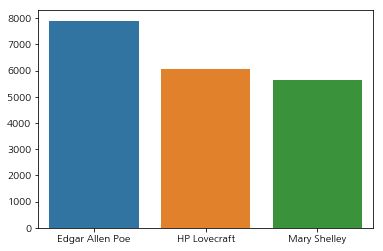

In [8]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}

x = train.author.map(z).unique()
y = train.author.value_counts().values
y
sns.barplot(x=x, y=y)

In [6]:
# 저자별로 데이터프레임을 나눈다.
train_eap = train[train["author"] == 'EAP']["text"]
train_hpl = train[train["author"] == 'HPL']["text"]
train_mws = train[train["author"] == 'MWS']["text"]

## Natural Language Processing

In [9]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import sent_tokenize,word_tokenize
from collections import Counter

In [10]:
def displayWordCloud(data = None, backgroundcolor = 'black',  width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()    

In [11]:
# Storing the first text element as a string
first_text = train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [12]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopword Removal 불용어 제거

일반적으로 코퍼스에서 자주 나타나는 단어는 학습 모델로서 학습이나 예측 프로세스에 실제로 기여하지 않아 다른 텍스트와 구별하지 못한다. 예를들어 조사, 접미사, i, me, my, it, this, that, is, are 등 과 같은 단어는 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는다. Stopwords는 "to"또는 "the"와 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋다. NLTK에는 153 개의 영어 불용어가 미리 정의되어 있다. 17개의 언어에 대해 정의되어 있으며 한국어는 없다.

In [13]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

153

In [14]:
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
print(first_text_list_cleaned)
print("="*90)
print("Length of original list: {0} words\n"
      "Length of list after stopwords removal: {1} words"
      .format(len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## Stemming and Lemmatization
### 스테밍(어간추출)
출처 : [어간 추출 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EC%96%B4%EA%B0%84_%EC%B6%94%EC%B6%9C)


어간 추출(語幹 抽出, 영어: stemming)은 형태론 및 정보 검색 분야에서 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것을 의미한다. 여기서 어간은 반드시 어근과 같아야 할 필요는 없으며, 어근과 차이가 있더라도 관련이 있는 단어들이 일정하게 동일한 어간으로 맵핑되게 하는 것이 어간 추출의 목적이다. 1960년대부터 컴퓨터 과학 분야에서 다양한 어간 추출 관련 알고리즘들이 연구되어 왔다. 많은 웹 검색 엔진들은 동일한 어간을 가진 단어들을 동의어로 취급하는 방식으로 질의어 확장을 하여 검색 결과의 품질을 높인다.

### Lemmatization 음소표기법

언어학에서 음소 표기법 (또는 lemmatization)은 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절 된 형태의 단어를 그룹화하는 과정이다. 동음이의어가 문맥에 따라 다른 의미를 갖는데 
<pre>
1) *배*가 맛있다. 
2) *배*를 타는 것이 재미있다. 
3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.
</pre>
위에 있는 3개의 문장에 있는 "배"는 모두 다른 의미를 갖는다. <br/>
레마타이제이션은 이때 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다.


In [15]:
stemmer = nltk.stem.PorterStemmer()

In [16]:
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [17]:
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of leaves is: leav


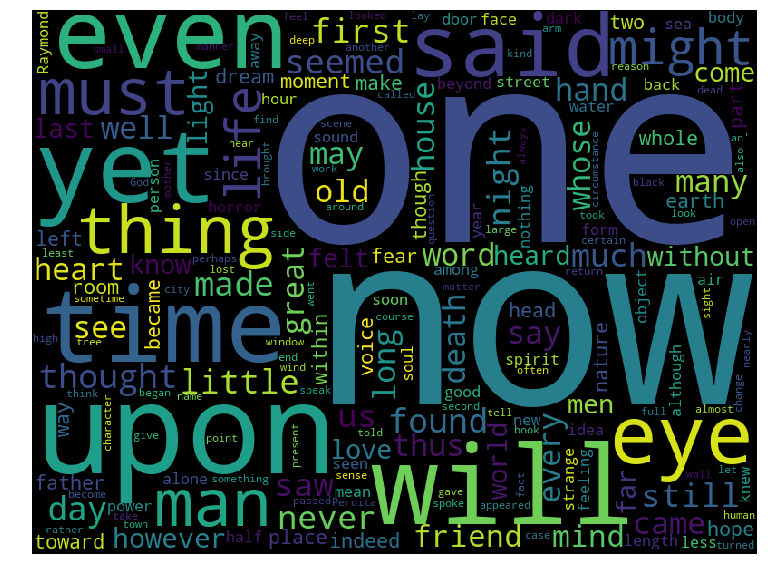

In [18]:
# 모든 단어에 대한 워드 클라우드를 그려본다.
displayWordCloud(' '.join(train['text']))

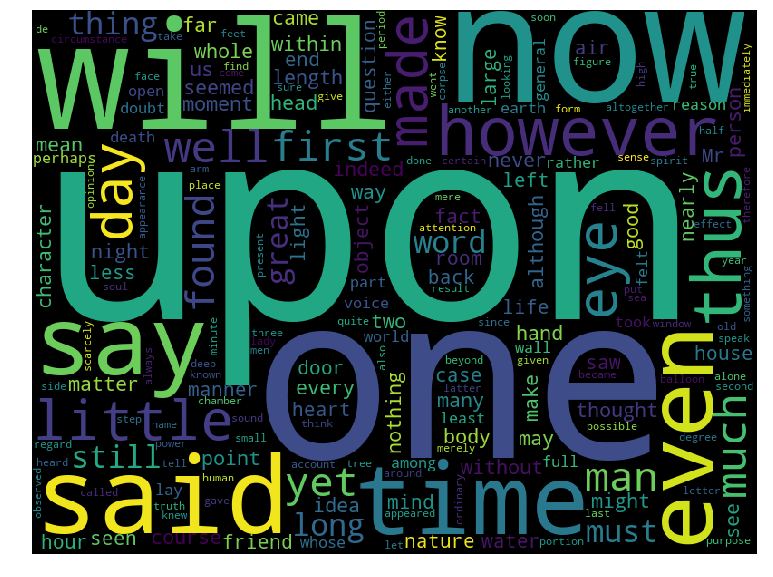

In [19]:
# 에드거 앨런 포(EAP)의 글에 대한 워드클라우드를 그려본다. 
displayWordCloud(' '.join(train_eap))

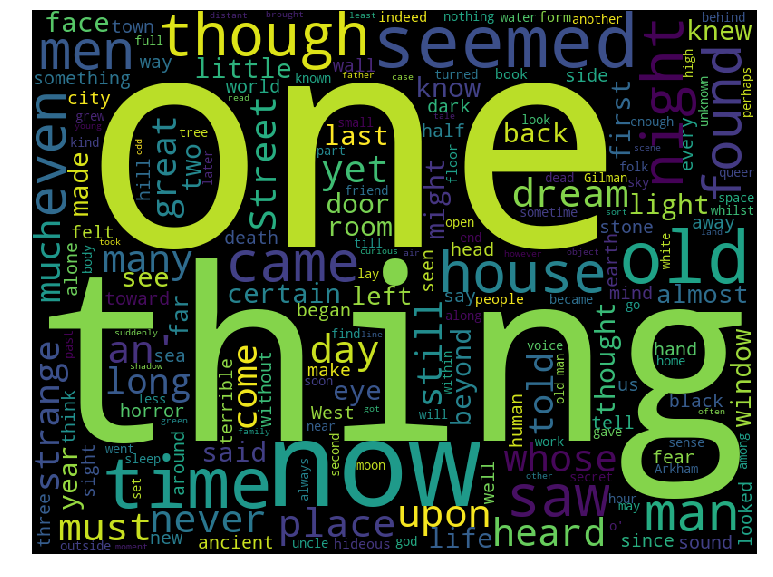

In [20]:
displayWordCloud(' '.join(train_hpl))

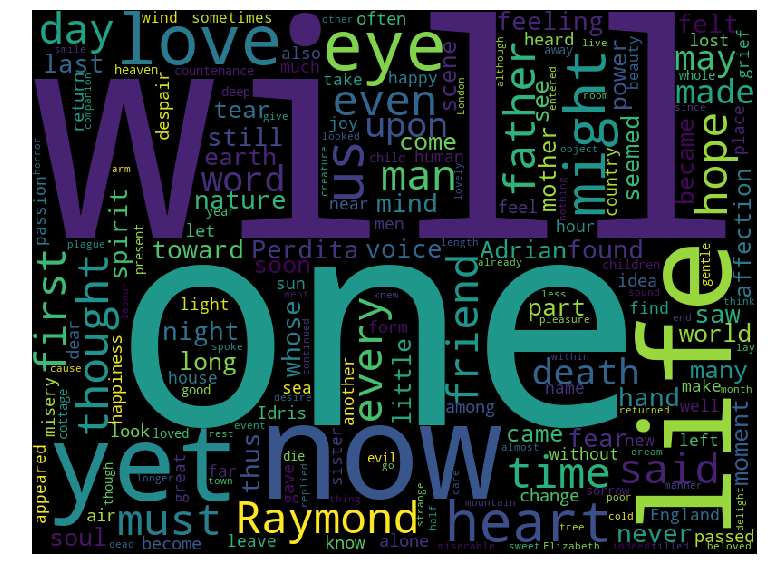

In [21]:
displayWordCloud(' '.join(train_mws))